# Bigfoot Bigger Data: An Investigation into Crunk Cryptids

In [141]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string
from nltk.corpus import stopwords
import string
import emoji
from datetime import timedelta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import rasterio
import rasterstats
import pandas as pd
import json
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.colors as pltc
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats
import pyproj

In [3]:
!pip install wordcloud
from wordcloud import WordCloud

In [6]:
dd = pd.read_csv(r"C:\Users\Hanna Willwerth\Bigfoot-Bigger-Data\Drinking_Dataset.csv")

In [7]:
#Begin process of transforming the data from wide to long. 
#Prepare the data by removing duplicates, creating the stub names.
dd=dd.dropna()

In [8]:
dd.head(2)

,State,Location,county_FIPS,2002 Both Sexes,2002 Females,2002 Males,2003 Both Sexes,2003 Females,2003 Males,2004 Both Sexes,...,2009 Males,2010 Both Sexes,2010 Females,2010 Males,2011 Both Sexes,2011 Females,2011 Males,2012 Both Sexes,2012 Females,2012 Males
0,Alabama,Alabama,1000.0,32.5,19.6,41.2,31.0,19.6,38.7,32.2,...,39.6,31.4,22.0,38.2,32.8,23.8,39.4,30.7,21.6,37.5
1,Alabama,Autauga County,1001.0,34.5,22.4,41.9,32.7,22.2,39.5,33.2,...,38.1,31.2,23.1,36.9,32.9,25.0,38.6,31.1,23.0,36.7


In [9]:
dd.columns = dd.columns.str.replace(" ","")

In [10]:
list(dd.columns[3:].str[4:]+dd.columns[3:].str[:4])

['BothSexes2002',
 'Females2002',
 'Males2002',
 'BothSexes2003',
 'Females2003',
 'Males2003',
 'BothSexes2004',
 'Females2004',
 'Males2004',
 'BothSexes2005',
 'Females2005',
 'Males2005',
 'BothSexes2006',
 'Females2006',
 'Males2006',
 'BothSexes2007',
 'Females2007',
 'Males2007',
 'BothSexes2008',
 'Females2008',
 'Males2008',
 'BothSexes2009',
 'Females2009',
 'Males2009',
 'BothSexes2010',
 'Females2010',
 'Males2010',
 'BothSexes2011',
 'Females2011',
 'Males2011',
 'BothSexes2012',
 'Females2012',
 'Males2012']

In [11]:
dd.columns = list(dd.columns[:3])+list(dd.columns[3:].str[4:]+dd.columns[3:].str[:4])

In [12]:
dd.columns

Index(['State', 'Location', 'county_FIPS', 'BothSexes2002', 'Females2002',
       'Males2002', 'BothSexes2003', 'Females2003', 'Males2003',
       'BothSexes2004', 'Females2004', 'Males2004', 'BothSexes2005',
       'Females2005', 'Males2005', 'BothSexes2006', 'Females2006', 'Males2006',
       'BothSexes2007', 'Females2007', 'Males2007', 'BothSexes2008',
       'Females2008', 'Males2008', 'BothSexes2009', 'Females2009', 'Males2009',
       'BothSexes2010', 'Females2010', 'Males2010', 'BothSexes2011',
       'Females2011', 'Males2011', 'BothSexes2012', 'Females2012',
       'Males2012'],
      dtype='object')

In [13]:
dd.head(2)

,State,Location,county_FIPS,BothSexes2002,Females2002,Males2002,BothSexes2003,Females2003,Males2003,BothSexes2004,...,Males2009,BothSexes2010,Females2010,Males2010,BothSexes2011,Females2011,Males2011,BothSexes2012,Females2012,Males2012
0,Alabama,Alabama,1000.0,32.5,19.6,41.2,31.0,19.6,38.7,32.2,...,39.6,31.4,22.0,38.2,32.8,23.8,39.4,30.7,21.6,37.5
1,Alabama,Autauga County,1001.0,34.5,22.4,41.9,32.7,22.2,39.5,33.2,...,38.1,31.2,23.1,36.9,32.9,25.0,38.6,31.1,23.0,36.7


In [14]:
set([x[:-4] for x in dd.columns[3:]])

{'BothSexes', 'Females', 'Males'}

In [15]:
dd_l=pd.wide_to_long(dd,stubnames=set([x[:-4] for x in dd.columns[3:]]),i=['State','Location','county_FIPS'],j='year').reset_index()

In [16]:
dd_l.head(5)

,State,Location,county_FIPS,year,Males,BothSexes,Females
0,Alabama,Alabama,1000.0,2002,41.2,32.5,19.6
1,Alabama,Alabama,1000.0,2003,38.7,31.0,19.6
2,Alabama,Alabama,1000.0,2004,40.5,32.2,20.3
3,Alabama,Alabama,1000.0,2005,37.2,30.3,20.2
4,Alabama,Alabama,1000.0,2006,37.5,30.7,21.5


In [42]:
#Now wide to long transformation of the drinking dataset is complete,
#read in the bigfoot sightings data; 
#clean and trim the data; make sure variable names are consistent;
#merge it with the drinking dataset on year, county, and state.
bf = pd.read_csv("Bigfoot_Dataset.csv")


In [43]:
bf.head(5)

,observation#,observed,location_details,county,state,county_FIPS,season,title,latitude,longitude,...,moon_phase,precip_intensity,precip_probability,precip_type,pressure,summary,uv_index,visibility,wind_bearing,wind_speed
0,1,From the top of this hill the river was almost...,The events that I can describe took place alon...,Autauga County,Alabama,1001,Unknown,Report 1783: Night hunters hear strange scream...,32.44560,-86.56530,...,0.97,0.0041,1.00,rain,1017.02,Humid and mostly cloudy throughout the day.,5.0,6.980,126.0,4.49
1,2,It was a few days after hurricane frederic. I ...,traveling south on hwy 138 from bayminette cro...,Baldwin County,Alabama,1003,Summer,Report 26513: Man recalls a sighting after Hur...,30.71130,-87.91833,...,0.79,0.0000,0.00,NaN,1012.42,Partly cloudy in the morning.,5.0,7.100,17.0,8.78
2,3,Sunday morning around 9 am I was driving on th...,off of 180 to foley beach express [Investigato...,Baldwin County,Alabama,1003,Fall,Report 71896: LAST SUNDAY: Possible road cross...,30.31786,-87.64934,...,0.58,0.0001,0.06,rain,1021.30,Partly cloudy throughout the day.,4.0,9.874,98.0,7.18
3,4,I have been reluctant to share my story becaus...,County Road 79 South and Highway 30,Barbour County,Alabama,1005,Winter,Report 27067: Motorists pulled over on a rural...,31.86801,-85.35995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,It was a hot afternoon in august. I heard sire...,smelled of a wet goat on it's charge. it was d...,Bibb County,Alabama,1007,Summer,Report 21714: Rescue workers describes possibl...,33.10000,-86.86000,...,0.04,0.0007,0.76,rain,1016.18,Mostly cloudy until afternoon.,6.0,5.150,332.0,1.09


In [44]:
bf['year']=pd.DatetimeIndex(bf['date']).year 

In [45]:
bf_212=bf.loc[(bf['year']>=2002)&(bf['year']<=2012)]

In [46]:
dd_l = dd_l.rename(columns={'State':'state','Location':'county'})

In [47]:
dd_l.shape

(34969, 7)

In [48]:
bf_212.shape

(1646, 31)

In [49]:
result = pd.merge(dd_l,bf_212,how='inner')

In [50]:
result.shape

(1624, 34)

### Results from the merge:

   - Bigfoot (2002-2012) dataframe was **1646 x 29**
   - Drinking dataframe was **34969 x 7**
   - Result dataframte is **1624 x 33** (I used 3 columns to merge)
   - We lost only `1.34%` of the obvservations we had for Bigfoot sightings 
   - Checked with geocodes that the location results has been done right!

In [51]:
result.iloc[49,11:15]

title        Report 16520: Possible vocalizations heard at ...
latitude                                                 34.34
longitude                                            -110.9725
date                                                 11/3/2006
Name: 49, dtype: object

In [52]:
bf_212.loc[(bf_212['latitude']==34.34)&(bf_212['longitude']==-110.9725)]

,observation#,observed,location_details,county,state,county_FIPS,season,title,latitude,longitude,...,precip_intensity,precip_probability,precip_type,pressure,summary,uv_index,visibility,wind_bearing,wind_speed,year
124,125,I heard the same sounds described in the Aug 2...,from payson you take Hwy 260 to the rim lakes ...,Coconino County,Arizona,4005,Fall,Report 16520: Possible vocalizations heard at ...,34.34,-110.9725,...,0.0,0.0,NaN,NaN,Clear throughout the day.,0.0,NaN,192.0,0.86,2006


In [53]:
bigfoot_data = pd.DataFrame(result)

In [36]:
#bigfoot_data = pd.read_csv(r"C:\Users\Hanna Willwerth\Bigfoot-Bigger-Data\merge_result.csv")

In [54]:
bigfoot_data.head(5) 

,state,county,county_FIPS,year,Males,BothSexes,Females,observation#,observed,location_details,...,moon_phase,precip_intensity,precip_probability,precip_type,pressure,summary,uv_index,visibility,wind_bearing,wind_speed
0,Alabama,Bibb County,1007.0,2007,39.7,32.8,22.0,5,It was a hot afternoon in august. I heard sire...,smelled of a wet goat on it's charge. it was d...,...,0.04,0.0007,0.76,rain,1016.18,Mostly cloudy until afternoon.,6.0,5.15,332.0,1.09
1,Alabama,Blount County,1009.0,2006,36.9,30.8,20.6,7,I'm really not sure what I saw. I was going ba...,"Exit 166 or 266 just above Birmingham, Al.",...,0.24,0.0005,1.00,rain,NaN,Mostly cloudy until afternoon.,8.0,8.46,338.0,5.90
2,Alabama,Clarke County,1025.0,2002,42.8,34.5,19.8,13,"I saw bigfoot twice in Chance, Alabama and my ...",Hwy 31 from Atmore to 84 west then right on co...,...,0.35,NaN,NaN,rain,NaN,Humid throughout the day.,0.0,NaN,NaN,NaN
3,Alabama,Clarke County,1025.0,2008,42.3,34.4,21.5,14,Me and my best friend were riding down a dirt ...,the location is between the oil well road and ...,...,0.03,0.0107,1.00,rain,1013.16,"Rain starting in the afternoon, continuing unt...",7.0,9.16,32.0,8.15
4,Alabama,Clay County,1027.0,2008,40.4,32.4,19.1,15,01192008 Suspicious knocking was heard about 3...,"(topozone.com map 33Â° 27.85'N, 85Â° 52.21'W -...",...,0.40,0.0023,0.67,snow,1022.46,Overcast until evening.,3.0,9.06,306.0,1.96


General Stats: HANNA
1. Sightings by state
2. time of years/month
3. other stuff
4. drinking stats
5. sightings by year (line chart)
6. binging drinking by year (line chart)

In [55]:
#Once the datasets were merged and cleaned,
#begin exploratory data analysis by looking at distributions of key variables
precip_type = bigfoot_data.groupby('precip_type')['observation#'].nunique()

In [56]:
precip_type

precip_type
rain    588
snow     72
Name: observation#, dtype: int64

array([[<AxesSubplot:title={'center':'visibility'}>]], dtype=object)

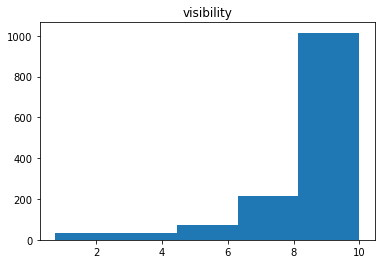

In [57]:
bigfoot_data.hist(column='visibility',grid=False, bins=5)

array([[<AxesSubplot:title={'center':'moon_phase'}>]], dtype=object)

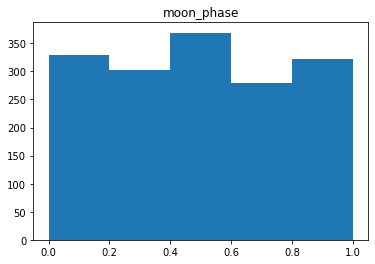

In [58]:
bigfoot_data.hist(column='moon_phase',grid=False, bins=5)

As demonstrated by the results above, most of the sightings happened on days with relatively good visibility (8 to 10 miles). This suggests that poor visibility may not be associated with bigfoot sightings. The distribution of sightings by moon phase was relatively even, although there did appear to be spike on the full moon (0.5).

In [60]:
#explore and visualize sightings by state
sightings_by_state = bigfoot_data.groupby('state')['observation#'].nunique()

In [61]:
sightings_by_state.sort_values(ascending=False).head()

state
Washington    203
Florida       128
Texas         124
California    109
Illinois       83
Name: observation#, dtype: int64

In [62]:
df_sightings_by_state = sightings_by_state.to_frame

<AxesSubplot:xlabel='state'>

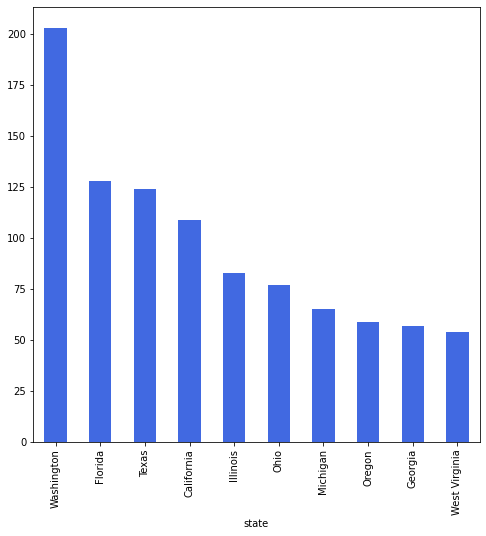

In [63]:
from matplotlib import cm
plt.figure(figsize = (8, 8)) 
cmap = cm.get_cmap('Spectral')
sightings_by_state.sort_values(ascending=False).head(10).plot.bar(color='royalblue')

Text(0.5, 1.0, 'Sightings Over Time')

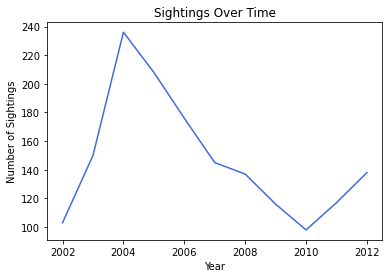

In [64]:
#explore sightings over time
f,ax = plt.subplots()
ax.plot(bigfoot_data['year'].value_counts().sort_index(),color="royalblue",label='Number of Sightings')
ax.set_ylabel('Number of Sightings')
ax.set_xlabel('Year')
plt.title('Sightings Over Time')

In [71]:
#explore total drinking rate by year
drinking_by_year = bigfoot_data.groupby('year')['BothSexes'].mean()

In [72]:
drinking_by_year

year
2002    32.830097
2003    33.138667
2004    33.251695
2005    31.700962
2006    31.667045
2007    33.284138
2008    33.062044
2009    33.774138
2010    33.956122
2011    35.652137
2012    34.547826
Name: BothSexes, dtype: float64

<AxesSubplot:xlabel='year'>

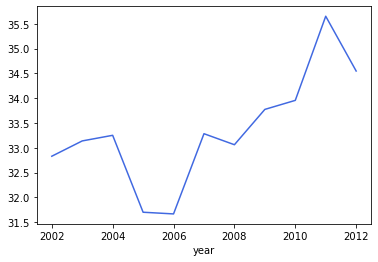

In [73]:
drinking_by_year.plot(color='royalblue')

In [74]:
#explore drinking rates by state
drinking_by_state = bigfoot_data.groupby('state')['BothSexes'].mean()

<AxesSubplot:xlabel='state'>

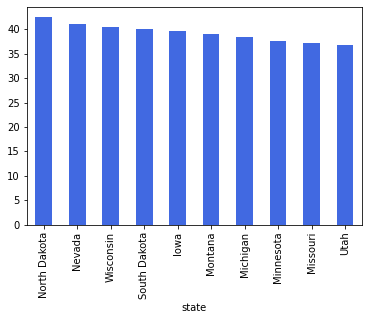

In [77]:
drinking_by_state.sort_values(ascending=False).head(10).plot.bar(color='royalblue')

## Text Analysis

In [87]:
#Create a clean text column
remv_punc = str.maketrans('','',string.punctuation + '“' +"‘"+'”'+'.')

bigfoot_data['observed'] = bigfoot_data['observed'].astype(str)

bigfoot_data['lower_text'] =  bigfoot_data['observed'].str.lower().str.replace("\n","")

bigfoot_data['clean_text'] = bigfoot_data.lower_text.str.translate(remv_punc)

bigfoot_data.head(5)

,state,county,county_FIPS,year,Males,BothSexes,Females,observation#,observed,location_details,...,precip_probability,precip_type,pressure,summary,uv_index,visibility,wind_bearing,wind_speed,lower_text,clean_text
0,Alabama,Bibb County,1007.0,2007,39.7,32.8,22.0,5,It was a hot afternoon in august. I heard sire...,smelled of a wet goat on it's charge. it was d...,...,0.76,rain,1016.18,Mostly cloudy until afternoon.,6.0,5.15,332.0,1.09,it was a hot afternoon in august. i heard sire...,it was a hot afternoon in august i heard siren...
1,Alabama,Blount County,1009.0,2006,36.9,30.8,20.6,7,I'm really not sure what I saw. I was going ba...,"Exit 166 or 266 just above Birmingham, Al.",...,1.00,rain,NaN,Mostly cloudy until afternoon.,8.0,8.46,338.0,5.90,i'm really not sure what i saw. i was going ba...,im really not sure what i saw i was going back...
2,Alabama,Clarke County,1025.0,2002,42.8,34.5,19.8,13,"I saw bigfoot twice in Chance, Alabama and my ...",Hwy 31 from Atmore to 84 west then right on co...,...,NaN,rain,NaN,Humid throughout the day.,0.0,NaN,NaN,NaN,"i saw bigfoot twice in chance, alabama and my ...",i saw bigfoot twice in chance alabama and my m...
3,Alabama,Clarke County,1025.0,2008,42.3,34.4,21.5,14,Me and my best friend were riding down a dirt ...,the location is between the oil well road and ...,...,1.00,rain,1013.16,"Rain starting in the afternoon, continuing unt...",7.0,9.16,32.0,8.15,me and my best friend were riding down a dirt ...,me and my best friend were riding down a dirt ...
4,Alabama,Clay County,1027.0,2008,40.4,32.4,19.1,15,01192008 Suspicious knocking was heard about 3...,"(topozone.com map 33Â° 27.85'N, 85Â° 52.21'W -...",...,0.67,snow,1022.46,Overcast until evening.,3.0,9.06,306.0,1.96,01192008 suspicious knocking was heard about 3...,01192008 suspicious knocking was heard about 3...


In [88]:
#Create a words list for each observation
from nltk.corpus import stopwords
sw_list = stopwords.words('english') + ['amp',''," "]

bigfoot_data['words'] = [x.split(" ") for x in bigfoot_data['clean_text']]

bigfoot_data['words'] = [list(set(x) - set(sw_list)) for x in bigfoot_data['words']]

bigfoot_data.head(5)

,state,county,county_FIPS,year,Males,BothSexes,Females,observation#,observed,location_details,...,precip_type,pressure,summary,uv_index,visibility,wind_bearing,wind_speed,lower_text,clean_text,words
0,Alabama,Bibb County,1007.0,2007,39.7,32.8,22.0,5,It was a hot afternoon in august. I heard sire...,smelled of a wet goat on it's charge. it was d...,...,rain,1016.18,Mostly cloudy until afternoon.,6.0,5.15,332.0,1.09,it was a hot afternoon in august. i heard sire...,it was a hot afternoon in august i heard siren...,"[sudden, pot, afternoon, tree, growth, like, b..."
1,Alabama,Blount County,1009.0,2006,36.9,30.8,20.6,7,I'm really not sure what I saw. I was going ba...,"Exit 166 or 266 just above Birmingham, Al.",...,rain,NaN,Mostly cloudy until afternoon.,8.0,8.46,338.0,5.90,i'm really not sure what i saw. i was going ba...,im really not sure what i saw i was going back...,"[arm, grey, birmingham, saw, tree, like, blend..."
2,Alabama,Clarke County,1025.0,2002,42.8,34.5,19.8,13,"I saw bigfoot twice in Chance, Alabama and my ...",Hwy 31 from Atmore to 84 west then right on co...,...,rain,NaN,Humid throughout the day.,0.0,NaN,NaN,NaN,"i saw bigfoot twice in chance, alabama and my ...",i saw bigfoot twice in chance alabama and my m...,"[attracted, twice, hes, seven, forty, saw, big..."
3,Alabama,Clarke County,1025.0,2008,42.3,34.4,21.5,14,Me and my best friend were riding down a dirt ...,the location is between the oil well road and ...,...,rain,1013.16,"Rain starting in the afternoon, continuing unt...",7.0,9.16,32.0,8.15,me and my best friend were riding down a dirt ...,me and my best friend were riding down a dirt ...,"[7, sheared, rd, saw, big, like, well, rabbit,..."
4,Alabama,Clay County,1027.0,2008,40.4,32.4,19.1,15,01192008 Suspicious knocking was heard about 3...,"(topozone.com map 33Â° 27.85'N, 85Â° 52.21'W -...",...,snow,1022.46,Overcast until evening.,3.0,9.06,306.0,1.96,01192008 suspicious knocking was heard about 3...,01192008 suspicious knocking was heard about 3...,"[follow, encountered, piece, immediately, sets..."


In [89]:
#Use countvectorizer to develop the word count lists.
vct = CountVectorizer(stop_words="english")

X = vct.fit_transform(list(bigfoot_data['clean_text']))

In [90]:
X

<1624x17924 sparse matrix of type '<class 'numpy.int64'>'
	with 172405 stored elements in Compressed Sparse Row format>

In [91]:
word_counts = pd.DataFrame(X.sum(axis=0))
word_counts.columns = vct.get_feature_names()
word_counts = word_counts.T

C:\Users\Hanna Willwerth\miniconda3\envs\ace592\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [92]:
word_counts = word_counts[0].sort_values(ascending=False)
word_counts.head(10)

heard    2636
like     2501
saw      1907
road     1890
just     1872
area     1648
time     1457
went     1331
woods    1316
got      1284
Name: 0, dtype: int64

In [93]:
#Remove action and other stop words from the word count list
words =  list(word_counts.index)
words.remove("like")
word_counts = word_counts.loc[words]

words.remove("just")
word_counts = word_counts.loc[words]

words.remove("went")
word_counts = word_counts.loc[words]

words.remove("got")
word_counts = word_counts.loc[words]

words.remove("did")
word_counts = word_counts.loc[words]

words.remove("heard")
word_counts = word_counts.loc[words]

words.remove("saw")
word_counts = word_counts.loc[words]

words.remove("looked")
word_counts = word_counts.loc[words]

In [94]:
#updated word count list
word_counts.head(10)

road       1890
area       1648
time       1457
woods      1316
night      1135
sound      1113
feet       1070
said       1015
thought     971
large       958
Name: 0, dtype: int64

In [95]:
#use word count list to create word cloud
wordcloud = WordCloud(stopwords=sw_list +['like','saw',"see"]).generate(str(text))

In [96]:
text = bigfoot_data['clean_text'].values

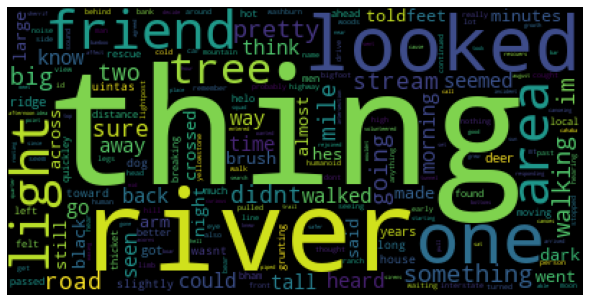

In [97]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [98]:
#import a image to use as a mask to create a wordcloud of bigfoot
from PIL import Image
import numpy as np

mask = np.array(Image.open(r"C:\Users\Hanna Willwerth\Bigfoot-Bigger-Data\bigfootpic.jpg"))[:-100,:,:]

mask

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[245, 245, 245],
        [255, 255, 255],
        [230, 230, 230],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [243, 243, 243],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

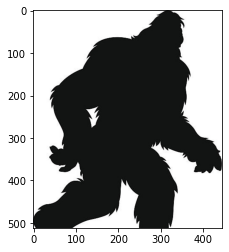

In [99]:
plt.imshow(mask[:,:,:])

In [100]:
wordcloud = WordCloud(stopwords=sw_list+['like','saw',"see"],\
                      mask=mask,
                      colormap="RdBu",
                      max_words=1000,
                      width=1200, 
                      height=800,
                      background_color="black",
                      font_path='arial').generate(str(text))

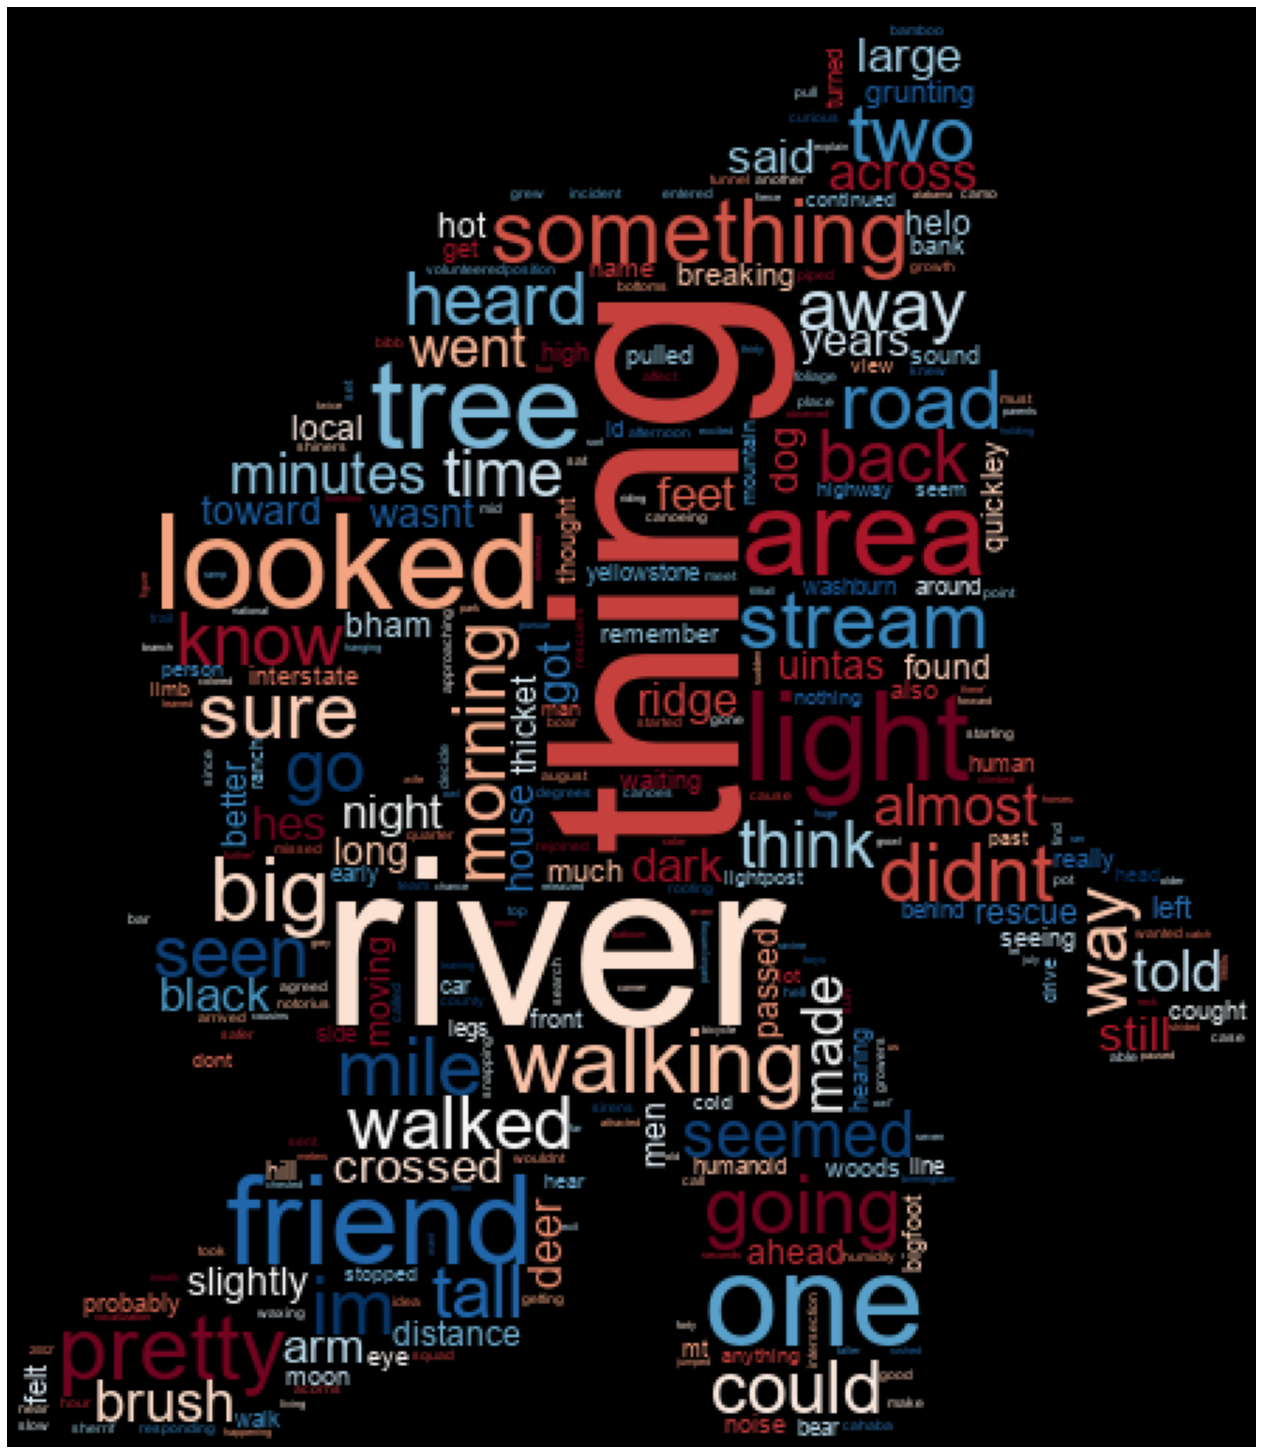

In [101]:
plt.figure(figsize = (20, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig("bigfoot.png",dpi=350,bbox_inches="tight")

In [102]:
#develop individual word count lists for each of the top five states for bigfoot sightings
bigfoot_dataWA = bigfoot_data[bigfoot_data.state=='Washington']

In [103]:
vct = CountVectorizer(stop_words="english")

X = vct.fit_transform(list(bigfoot_dataWA['clean_text']))

word_counts = pd.DataFrame(X.sum(axis=0))
word_counts.columns = vct.get_feature_names()
word_counts = word_counts.T

word_counts = word_counts[0].sort_values(ascending=False)


words =  list(word_counts.index)
words.remove("like")
word_counts = word_counts.loc[words]

words.remove("just")
word_counts = word_counts.loc[words]

words.remove("went")
word_counts = word_counts.loc[words]

words.remove("got")
word_counts = word_counts.loc[words]

words.remove("did")
word_counts = word_counts.loc[words]

words.remove("heard")
word_counts = word_counts.loc[words]

words.remove("saw")
word_counts = word_counts.loc[words]

words.remove("looked")
word_counts = word_counts.loc[words]

word_counts.head(10)

C:\Users\Hanna Willwerth\miniconda3\envs\ace592\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


road     316
area     244
time     228
sound    202
night    173
away     169
feet     158
said     140
left     139
didnt    135
Name: 0, dtype: int64

In [104]:
bigfoot_dataFL = bigfoot_data[bigfoot_data.state=='Florida']
vct = CountVectorizer(stop_words="english")

X = vct.fit_transform(list(bigfoot_dataFL['clean_text']))

word_counts = pd.DataFrame(X.sum(axis=0))
word_counts.columns = vct.get_feature_names()
word_counts = word_counts.T

word_counts = word_counts[0].sort_values(ascending=False)


words =  list(word_counts.index)
words.remove("like")
word_counts = word_counts.loc[words]

words.remove("just")
word_counts = word_counts.loc[words]

words.remove("went")
word_counts = word_counts.loc[words]

words.remove("got")
word_counts = word_counts.loc[words]

words.remove("did")
word_counts = word_counts.loc[words]

words.remove("heard")
word_counts = word_counts.loc[words]

words.remove("saw")
word_counts = word_counts.loc[words]

words.remove("looked")
word_counts = word_counts.loc[words]

word_counts.head(10)

C:\Users\Hanna Willwerth\miniconda3\envs\ace592\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


road        164
area        145
woods       138
time        107
tree         86
sound        79
feet         79
creature     76
away         75
said         71
Name: 0, dtype: int64

In [105]:
bigfoot_dataTX = bigfoot_data[bigfoot_data.state=='Texas']
vct = CountVectorizer(stop_words="english")

X = vct.fit_transform(list(bigfoot_dataTX['clean_text']))

word_counts = pd.DataFrame(X.sum(axis=0))
word_counts.columns = vct.get_feature_names()
word_counts = word_counts.T

word_counts = word_counts[0].sort_values(ascending=False)


words =  list(word_counts.index)
words.remove("like")
word_counts = word_counts.loc[words]

words.remove("just")
word_counts = word_counts.loc[words]

words.remove("went")
word_counts = word_counts.loc[words]

words.remove("got")
word_counts = word_counts.loc[words]

words.remove("did")
word_counts = word_counts.loc[words]

words.remove("heard")
word_counts = word_counts.loc[words]

words.remove("saw")
word_counts = word_counts.loc[words]

words.remove("looked")
word_counts = word_counts.loc[words]

word_counts.head(10)

C:\Users\Hanna Willwerth\miniconda3\envs\ace592\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


road      154
area      152
woods     146
time      102
tree      102
feet       93
animal     92
large      86
turned     84
came       82
Name: 0, dtype: int64

In [106]:
bigfoot_dataCA = bigfoot_data[bigfoot_data.state=='California']
vct = CountVectorizer(stop_words="english")

X = vct.fit_transform(list(bigfoot_dataCA['clean_text']))

word_counts = pd.DataFrame(X.sum(axis=0))
word_counts.columns = vct.get_feature_names()
word_counts = word_counts.T

word_counts = word_counts[0].sort_values(ascending=False)


words =  list(word_counts.index)
words.remove("like")
word_counts = word_counts.loc[words]

words.remove("just")
word_counts = word_counts.loc[words]

words.remove("went")
word_counts = word_counts.loc[words]

words.remove("got")
word_counts = word_counts.loc[words]

words.remove("did")
word_counts = word_counts.loc[words]

words.remove("heard")
word_counts = word_counts.loc[words]

words.remove("saw")
word_counts = word_counts.loc[words]

words.remove("looked")
word_counts = word_counts.loc[words]

word_counts.head(10)

C:\Users\Hanna Willwerth\miniconda3\envs\ace592\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


time       132
area       121
sound      114
road       101
night       93
feet        92
bigfoot     76
lake        73
away        72
bear        69
Name: 0, dtype: int64

In [107]:
bigfoot_dataIL = bigfoot_data[bigfoot_data.state=='Illinois']
vct = CountVectorizer(stop_words="english")

X = vct.fit_transform(list(bigfoot_dataIL['clean_text']))

word_counts = pd.DataFrame(X.sum(axis=0))
word_counts.columns = vct.get_feature_names()
word_counts = word_counts.T

word_counts = word_counts[0].sort_values(ascending=False)


words =  list(word_counts.index)
words.remove("like")
word_counts = word_counts.loc[words]

words.remove("just")
word_counts = word_counts.loc[words]

words.remove("went")
word_counts = word_counts.loc[words]

words.remove("got")
word_counts = word_counts.loc[words]

words.remove("did")
word_counts = word_counts.loc[words]

words.remove("heard")
word_counts = word_counts.loc[words]

words.remove("saw")
word_counts = word_counts.loc[words]

word_counts.head(10)

C:\Users\Hanna Willwerth\miniconda3\envs\ace592\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


road       79
time       69
area       68
woods      64
stan       62
deer       60
tree       57
know       56
house      52
walking    51
Name: 0, dtype: int64

In [109]:
#Conduct sentiment analysis by generating polarity scores for each observation
#Identify observations with the most positive and most negative sentiment scores
sid = SentimentIntensityAnalyzer()

pol_scores = [sid.polarity_scores(x)['compound'] for x in bigfoot_data['clean_text']]

bigfoot_data['sentiment'] = pd.Series(pol_scores)

#sent_ts = bigfoot_data.set_index("time_stamp").sort_index()

In [110]:
#pd.set_option('display.max_colwidth', None)
bigfoot_data.sort_values("sentiment")[['observed','sentiment']].head()

,observed,sentiment
1404,This is a compilation of experiences over a pe...,-0.9985
1614,[Investigators's interview notes begin here. T...,-0.9976
1340,Upon request of Chris Bradley (BFRO investigat...,-0.9975
708,Let me start out saying I grew up in the woods...,-0.9964
150,"First, as a matter of background, I want to te...",-0.9959


In [111]:
bigfoot_data.sort_values("sentiment", ascending=False)[['observed','sentiment']].head()

,observed,sentiment
1096,I have debated whether or not to report my enc...,0.9994
213,"Okay, I just spent about ten or fifteen minute...",0.9978
25,"I had noted on my Limestone, Alabama Spring 19...",0.9975
1471,"OK, last night I went home from Walmart in Spa...",0.9964
1570,"On September 28th, 2007, my good friend and I ...",0.9962


In [112]:
#Calculate median and mean scores, distribution of sentiment scores
bigfoot_data['sentiment'].median()

0.2037

In [113]:
bigfoot_data['sentiment'].mean()

0.1138436576354679

array([[<AxesSubplot:title={'center':'sentiment'}>]], dtype=object)

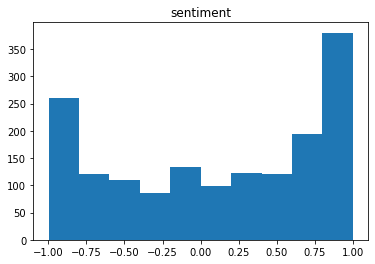

In [117]:
bigfoot_data.hist(column='sentiment',grid=False, bins=10)

In [114]:
#plot sentiment scores over time
sentiment_by_year = bigfoot_data.groupby('year')['sentiment'].mean()

<AxesSubplot:xlabel='year'>

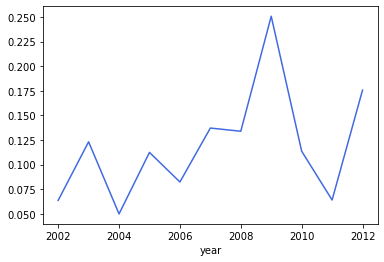

In [122]:
sentiment_by_year.plot(color='royalblue')

## Regression Analysis

In [126]:
df = bigfoot_data

In [127]:
#Create sub-datasets by state:
df_sightings_s = df.groupby('state')['observed'].count().reset_index()
df_females_s = df.groupby('state')['Females'].mean().reset_index()
df_males_s = df.groupby('state')['Males'].mean().reset_index()
df_both_s = df.groupby('state')['BothSexes'].mean().reset_index()

In [128]:
#Merge sub-datasets together for state correlation analysis:
df_corr_state = df_sightings_s.merge(df_females_s)
df_corr_state = df_corr_state.merge(df_males_s)
df_corr_state = df_corr_state.merge(df_both_s)
df_corr_state.head(5)

,state,observed,Females,Males,BothSexes
0,Alabama,37,20.770270,38.916216,31.637838
1,Arizona,32,25.184375,40.553125,34.075000
2,Arkansas,37,23.702703,39.727027,33.332432
3,California,109,23.497248,37.111927,30.973394
4,Colorado,33,23.615152,38.693939,31.866667


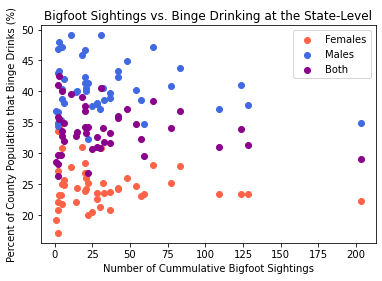

In [129]:
#Scatterplot of number of observations and binge drinking percentage at the state-level: 
fig, ax = plt.subplots()
plt.scatter(df_corr_state['observed'],df_corr_state['Females'], color='tomato')
plt.scatter(df_corr_state['observed'],df_corr_state['Males'], color='royalblue')
plt.scatter(df_corr_state['observed'],df_corr_state['BothSexes'], color='darkmagenta')
plt.title('Bigfoot Sightings vs. Binge Drinking at the State-Level')
ax.set_xlabel('Number of Cummulative Bigfoot Sightings')
ax.set_ylabel('Percent of County Population that Binge Drinks (%)')
plt.legend(["Females", "Males", "Both"], loc=0)
plt.show()

In [130]:
#Calculate correlations between the number of observations and binge drinking percentage at the county-level:
female_corr = df_corr_state['observed'].corr(df_corr_state['Females'])
print(female_corr)
male_corr = df_corr_state['observed'].corr(df_corr_state['Males'])
print(male_corr)
both_corr = df_corr_state['observed'].corr(df_corr_state['BothSexes'])
print(both_corr)

-0.10808823428538118
-0.174871805989576
-0.1487039731253531


In [131]:
#Create sub-datasets by county FIPS code:
df_sightings_c = df.groupby('county_FIPS')['observed'].count().reset_index()
df_females_c = df.groupby('county_FIPS')['Females'].mean().reset_index()
df_males_c = df.groupby('county_FIPS')['Males'].mean().reset_index()
df_both_c = df.groupby('county_FIPS')['BothSexes'].mean().reset_index()

In [132]:
#Merge sub-datasets together for county correlation analysis:
df_corr_county = df_sightings_c.merge(df[['county_FIPS','state','county']])
df_corr_county = df_corr_county.merge(df_females_c)
df_corr_county = df_corr_county.merge(df_males_c)
df_corr_county = df_corr_county.merge(df_both_c)
df_corr_county.head(5)

,county_FIPS,observed,state,county,Females,Males,BothSexes
0,1007.0,1,Alabama,Bibb County,22.00,39.70,32.80
1,1009.0,1,Alabama,Blount County,20.60,36.90,30.80
2,1025.0,2,Alabama,Clarke County,20.65,42.55,34.45
3,1025.0,2,Alabama,Clarke County,20.65,42.55,34.45
4,1027.0,1,Alabama,Clay County,19.10,40.40,32.40


C:\Users\Hanna Willwerth\AppData\Local\Temp\ipykernel_15440\2811788907.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(df_corr_county['observed'],p(df_corr_county['observed']),"r--", color="purple")
C:\Users\Hanna Willwerth\AppData\Local\Temp\ipykernel_15440\2811788907.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(df_corr_county['observed'],p(df_corr_county['observed']),"r--", color="red")
C:\Users\Hanna Willwerth\AppData\Local\Temp\ipykernel_15440\2811788907.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(df_corr_county['observed'],p(df_corr_county['observed']),"r--", color="navy")


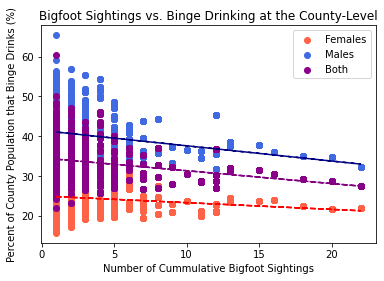

In [133]:
#Scatterplot of number of observations and binge drinking percentage at the county-level: 
fig, ax = plt.subplots()
plt.scatter(df_corr_county['observed'],df_corr_county['Females'], color='tomato')
plt.scatter(df_corr_county['observed'],df_corr_county['Males'], color='royalblue')
plt.scatter(df_corr_county['observed'],df_corr_county['BothSexes'], color='darkmagenta')
plt.title('Bigfoot Sightings vs. Binge Drinking at the County-Level')
ax.set_xlabel('Number of Cummulative Bigfoot Sightings')
ax.set_ylabel('Percent of County Population that Binge Drinks (%)')
plt.legend(["Females", "Males", "Both"], loc=0)

#Adds trendlines: 
z = np.polyfit(df_corr_county['observed'], df_corr_county['BothSexes'], 1)
p = np.poly1d(z)
plt.plot(df_corr_county['observed'],p(df_corr_county['observed']),"r--", color="purple")
z = np.polyfit(df_corr_county['observed'], df_corr_county['Females'], 1)
p = np.poly1d(z)
plt.plot(df_corr_county['observed'],p(df_corr_county['observed']),"r--", color="red")
z = np.polyfit(df_corr_county['observed'], df_corr_county['Males'], 1)
p = np.poly1d(z)
plt.plot(df_corr_county['observed'],p(df_corr_county['observed']),"r--", color="navy")

plt.show()

In [134]:
#Calculate correlations between the number of observations and binge drinking percentage at the county-level:
female_corr = df_corr_county['observed'].corr(df_corr_county['Females'])
print(female_corr)
male_corr = df_corr_county['observed'].corr(df_corr_county['Males'])
print(male_corr)
both_corr = df_corr_county['observed'].corr(df_corr_county['BothSexes'])
print(both_corr)

-0.2152833897778023
-0.34577628806766714
-0.34006106203618297


In [135]:
#Create and merge the sub-datasets for time-series analysis:
df_year_count = df.groupby('year')['observed'].count().reset_index()
df_year_both = df.groupby('year')['BothSexes'].mean().reset_index()
df_year_female = df.groupby('year')['Females'].mean().reset_index()
df_year_male = df.groupby('year')['Males'].mean().reset_index()
df_year = df_year_count.merge(df_year_both)
df_year = df_year.merge(df_year_female)
df_year = df_year.merge(df_year_male)
df_year.head(11)

,year,observed,BothSexes,Females,Males
0,2002,103,32.830097,24.712621,38.843689
1,2003,150,33.138667,24.062667,39.660667
2,2004,236,33.251695,24.179661,39.733051
3,2005,208,31.700962,22.370192,38.516346
4,2006,176,31.667045,23.139205,38.178409
5,2007,145,33.284138,24.302759,39.886897
6,2008,137,33.062044,24.189781,39.767153
7,2009,116,33.774138,24.612069,40.506897
8,2010,98,33.956122,25.239796,40.713265
9,2011,117,35.652137,26.237607,42.980342


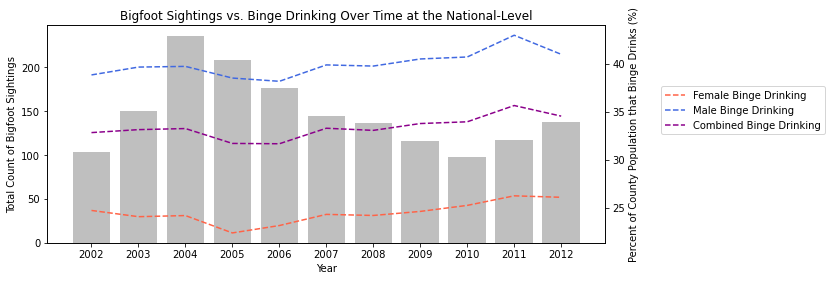

In [136]:
#Plot drinking and sightings data over time at the national-level: 
fig,ax1 = plt.subplots(figsize=(10,4))
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Count of Bigfoot Sightings')
ax1.bar(df_year['year'],df_year['observed'],alpha=0.5, color="grey")
ax2=ax1.twinx()
ax2.set_ylabel('Percent of County Population that Binge Drinks (%)')
ax2.plot(df_year['year'],df_year['Females'],color="tomato", ls="--")
ax2.plot(df_year['year'],df_year['Males'],color="royalblue", ls="--")
ax2.plot(df_year['year'],df_year['BothSexes'],color="darkmagenta", ls="--")
plt.title('Bigfoot Sightings vs. Binge Drinking Over Time at the National-Level')
plt.xticks(np.arange(2002, 2013, 1))
plt.legend(["Female Binge Drinking", "Male Binge Drinking", "Combined Binge Drinking"], bbox_to_anchor=(1.1,0.5), loc="lower left", borderaxespad=0)

In [143]:
!pip install statsmodels

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

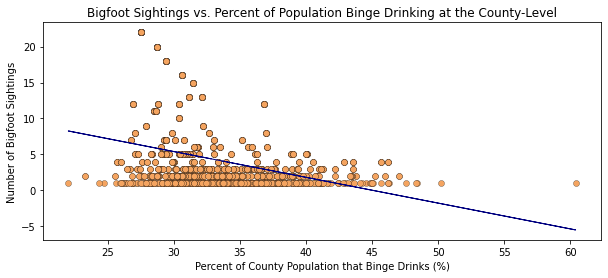

In [144]:
#Create linear regression of Bigfoot sightings and binge drinking:
df_corr_county.to_numpy()
y = df_corr_county['observed'].values.reshape(-1, 1)
x = df_corr_county['BothSexes'].values.reshape(-1, 1)
reg = LinearRegression()
reg.fit(x,y)
predictions = reg.predict(x)
plt.figure(figsize=(10,4))
plt.scatter(x, y,c='sandybrown',edgecolor='black',linewidth=0.25)
plt.plot(x, predictions, c='navy', linewidth=1)
plt.title('Bigfoot Sightings vs. Percent of Population Binge Drinking at the County-Level')
plt.ylabel('Number of Bigfoot Sightings')
plt.xlabel('Percent of County Population that Binge Drinks (%)')
plt.show()

In [145]:
#Produce regression summary results for above model:
results = sm.OLS(y,sm.add_constant(x)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     212.1
Date:                Sun, 01 May 2022   Prob (F-statistic):           3.01e-45
Time:                        17:36:50   Log-Likelihood:                -4681.0
No. Observations:                1624   AIC:                             9366.
Df Residuals:                    1622   BIC:                             9377.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1498      0.824     19.589      0.0